In [ ]:
# after validation data train
df_train = pd.read_excel('../data/data_valid/main_indobert_train.xlsx', sheet_name='data_valid')
df_test = pd.read_excel('../data/data_valid/main_indobert_train.xlsx', sheet_name='data_test')
le = LabelEncoder()
df_train['Encoded_Label_Valid'] = le.fit_transform(df_train['Validation'])
df_test['Encoded_Label'] = le.transform(df_test['Label_Bert'])

In [ ]:
# 3. Handle Imbalanced Data
# =============================
df_neg = df_train[df_train['Validation'] == 'negative'].copy()
aug = naw.SynonymAug(aug_src='wordnet')
df_neg['Augmented_Text'] = df_neg['Text Normalization'].apply(lambda x: aug.augment(x))
df_neg_augmented = df_neg.copy()
df_neg_augmented['Text Normalization'] = df_neg_augmented['Augmented_Text']
df_neg_final = pd.concat([df_neg, df_neg_augmented], ignore_index=True)

df_other = df_train[df_train['Validation'] != 'negative']
df_aug_combined = pd.concat([df_other, df_neg_final], ignore_index=True)

max_count = df_aug_combined['Encoded_Label_Valid'].value_counts().max()
df_balanced = pd.concat([
    resample(sub_df, replace=True, n_samples=max_count, random_state=42)
    for _, sub_df in df_aug_combined.groupby('Encoded_Label_Valid')
], ignore_index=True)

In [ ]:
# 4. Tokenization
# =============================
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_balanced['Text Normalization'])

X_train = pad_sequences(tokenizer.texts_to_sequences(df_balanced['Text Normalization']),
                        maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y_train = df_balanced['Encoded_Label'].values

X_test = pad_sequences(tokenizer.texts_to_sequences(df_test['Text Normalization']),
                       maxlen=MAX_SEQUENCE_LENGTH, padding='post')
y_test = df_test['Encoded_Label'].values

In [ ]:
# 5. Load GloVe Embedding
# =============================
embedding_index = {}
with open("/media/atrkeffect/BOS/TA/tweet/code/src/glove/glove.6B.300d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

In [ ]:
# 6. Build Model with Best Param
# =============================
def build_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedding = Embedding(input_dim=len(word_index)+1,
                          output_dim=embedding_dim,
                          weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH,
                          trainable=True)(input_layer)
    cnn = Conv1D(128, 7, activation='relu')(embedding)
    cnn = GlobalAveragePooling1D()(cnn)
    lstm = Bidirectional(LSTM(64))(embedding)
    x = concatenate([cnn, lstm])
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [ ]:
# 9. 5-Fold Cross Validation on Balanced Train Data
# =============================
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precisions, recalls, f1s, losses = [], [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"\nFold {fold}/5")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = build_model()
    model.fit(X_tr, y_tr, epochs=10, batch_size=32, verbose=0)

    y_pred_proba = model.predict(X_val)
    y_pred = y_pred_proba.argmax(axis=1)

    accs.append(accuracy_score(y_val, y_pred))
    precisions.append(precision_score(y_val, y_pred, average='macro'))
    recalls.append(recall_score(y_val, y_pred, average='macro'))
    f1s.append(f1_score(y_val, y_pred, average='macro'))
    losses.append(log_loss(y_val, y_pred_proba))

# Summary
print("\n===== 5-Fold CV Results on Balanced Training Data =====")
print("Average Accuracy: {:.2f}%".format(np.mean(accs) * 100))
print("Average Precision: {:.2f}%".format(np.mean(precisions) * 100))
print("Average Recall: {:.2f}%".format(np.mean(recalls) * 100))
print("Average F1-Score: {:.2f}%".format(np.mean(f1s) * 100))
print("Average Log Loss: {:.2f}".format(np.mean(losses)))


Fold 1/5


/home/atrkeffect/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Fold 2/5


/home/atrkeffect/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Fold 3/5


/home/atrkeffect/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Fold 4/5


/home/atrkeffect/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

Fold 5/5


/home/atrkeffect/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step

===== 5-Fold CV Results on Balanced Training Data =====
Average Accuracy: 86.69%
Average Precision: 84.14%
Average Recall: 84.09%
Average F1-Score: 84.02%
Average Log Loss: 0.58


In [ ]:
# =============================
# 10. Final Training on Full Train Set & Evaluation on Test Set
# =============================

# Retrain the model on the full balanced training set
final_model = build_model()
final_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict on test set
y_test_pred_proba = final_model.predict(X_test)
y_test_pred = y_test_pred_proba.argmax(axis=1)

# Evaluate
print("\n===== Evaluation on Final Test Set =====")
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_test_pred) * 100))
print("Precision: {:.2f}%".format(precision_score(y_test, y_test_pred, average='macro') * 100))
print("Recall: {:.2f}%".format(recall_score(y_test, y_test_pred, average='macro') * 100))
print("F1-Score: {:.2f}%".format(f1_score(y_test, y_test_pred, average='macro') * 100))
print("Log Loss: {:.4f}".format(log_loss(y_test, y_test_pred_proba)))

Epoch 1/10


/home/atrkeffect/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5818 - loss: 0.9068
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7637 - loss: 0.6055
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8824 - loss: 0.3192
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9329 - loss: 0.1797
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9505 - loss: 0.1260
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9625 - loss: 0.1021
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9664 - loss: 0.0843
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9702 - loss: 0.0706
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9678 - loss: 0.0812
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9685 - loss: 0.0717
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

===== Evaluation on Final Test Set =====
Accuracy: 65.21%
Precision: 56.45%
Recall: 54.29%
F1-Score: 54.62%
Log Loss: 1

In [ ]:
# 10. Final Training on Full Train Set & Evaluation on Test Set
# =============================

# Train Final Model on Balanced Training Set
model = build_model()
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict on Test Set
y_pred_proba = model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

# Decode label integer back to original class
y_true_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.5662 - loss: 0.9073
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7544 - loss: 0.6117
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8881 - loss: 0.3300
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9425 - loss: 0.1706
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9435 - loss: 0.1360
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9607 - loss: 0.1154
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9646 - loss: 0.0892
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9658 - loss: 0.0834
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9697 - loss: 0.0690
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9734 - loss: 0.0717
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report (Test Set):\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

Classification Report (Test Set):

              precision    recall  f1-score   support

    negative       0.48      0.46      0.47       110
     neutral       0.51      0.47      0.49        72
    positive       0.75      0.77      0.76       275

    accuracy                           0.65       457
   macro avg       0.58      0.57      0.57       457
weighted avg       0.65      0.65      0.65       457



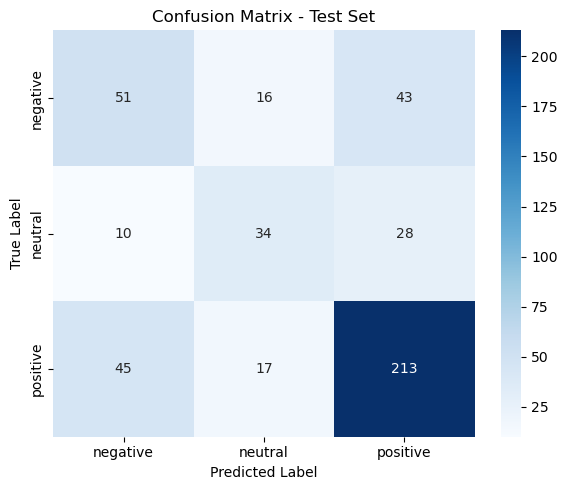

In [ ]:
# 11. Visualize Results
# =============================
# 1. Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=le.classes_)

# Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

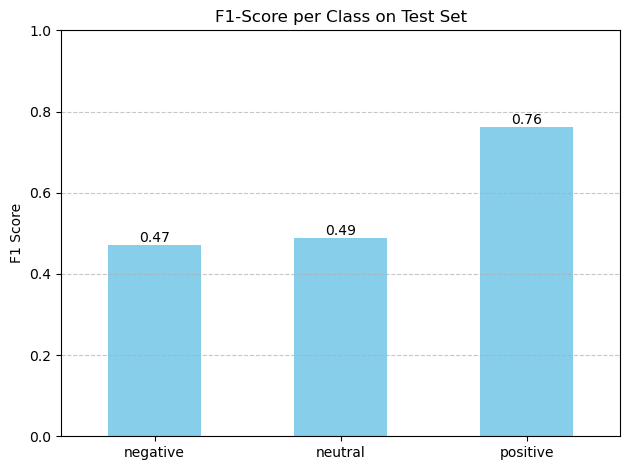

In [ ]:
# 2. Bar chart akurasi tiap kelas
import pandas as pd

report = classification_report(y_true_labels, y_pred_labels, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Bar chart F1 per kelas
ax = df_report.iloc[:-3]['f1-score'].plot(kind='bar', color='skyblue')
plt.title("F1-Score per Class on Test Set")
plt.ylabel("F1 Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add data labels above bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# save results
df_test['True Label'] = y_true_labels
df_test['Predicted Label'] = y_pred_labels

df_test[['Text Normalization', 'True Label', 'Predicted Label']].to_csv(
    '../data/output/test_predictions.csv', index=False)